In [1]:
!git clone -b update-gluonts https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 505, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 505 (delta 154), reused 109 (delta 109), pack-reused 312 (from 3)
Receiving objects: 100% (505/505), 283.34 KiB | 9.44 MiB/s, done.
Resolving deltas: 100% (252/252), done.


In [2]:
cd /content/lag-llama

/content/lag-llama


In [3]:
!pip uninstall jax jaxlib tensorboard -y

Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
Found existing installation: tensorboard 2.18.0
Uninstalling tensorboard-2.18.0:
  Successfully uninstalled tensorboard-2.18.0


In [4]:
!pip install -U -r requirements.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127

In [5]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 94.0MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


## Imports

We import the required packages and the lag llama estimator object which we can use to make predictions.

In [6]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

<ipython-input-6-3749d135369e>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
import sys
from types import ModuleType

# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

In [8]:
'''def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cuda", batch_size=64, nonnegative_pred_samples=True):
    ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only=False)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

    return forecasts, tss'''

## Fine-tuning

Let us fine-tune the Lag-Llama base model with a few data-specific changes. Feel Free to change the hyperparameters below:

In [9]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [10]:
import pandas as pd

data_dir = '/content/drive/MyDrive/Batteries/more_data/total/b1c0_for_model.csv'  # adjust if needed
df_mine = pd.read_csv(data_dir, parse_dates=True)
df_mine

,cycle_index,charge_capacity,discharge_capacity,internal_resistance,temperature_mean,temperature_min,temperature_max
0,3.0,1.071674,1.071900,0.016724,31.931490,29.604385,35.692978
1,4.0,1.072304,1.072510,0.016681,31.932603,29.744202,35.680588
2,5.0,1.072970,1.073174,0.016662,31.959322,29.644709,35.728691
3,6.0,1.073491,1.073576,0.016623,31.961062,29.752932,35.711758
4,7.0,1.073922,1.073992,0.016600,31.900562,29.564377,35.615650
...,...,...,...,...,...,...,...
1844,1847.0,0.885568,0.885435,0.018263,32.432079,31.080084,35.415527
1845,1848.0,0.884639,0.884546,0.018619,31.683310,28.951157,36.136974
1846,1849.0,0.884495,0.884624,0.018133,32.700542,30.243074,36.786781
1847,1850.0,0.884329,0.884331,0.018123,32.990592,30.337559,36.923153


In [42]:

# 1) Imports
import os, glob
import pandas as pd
from sklearn.model_selection import train_test_split
from gluonts.dataset.pandas import PandasDataset
import torch

# 2) Directory with your per-cycle CSVs
data_dir = '/content/drive/MyDrive/Batteries/more_data/total'  # adjust as needed
files = glob.glob(os.path.join(data_dir, '*_for_model.csv'))
if not files:
    raise FileNotFoundError(f"No CSVs found in {data_dir}")

# 3) Load each CSV into dfs_dict
dfs_dict = {}
for fp in files:
    series_id = os.path.basename(fp).replace('_for_model.csv','')
    df = pd.read_csv(fp)
    df['timestamp'] = pd.to_datetime(df['cycle_index'], unit='D', origin=pd.Timestamp("2000-01-01"))
    df = df.set_index('timestamp').drop(columns=['cycle_index']).astype('float32')
    dfs_dict[series_id] = df

# 4) Split series IDs
all_ids = sorted(dfs_dict)
train_ids, temp_ids = train_test_split(all_ids, train_size=90, random_state=42)
val_ids, test_ids   = train_test_split(temp_ids, train_size=20, random_state=42)

# 5) Build PandasDatasets
sensor_cols = ['charge_capacity',
 'discharge_capacity',
 'internal_resistance',
 'temperature_mean',
 'temperature_min',
 'temperature_max']

def build_pds(split_ids):
    subset = {sid: dfs_dict[sid] for sid in split_ids}
    return subset #PandasDataset(dataframes=subset, target=sensor_cols, freq="1D")

train_ds = build_pds(train_ids)
val_ds   = build_pds(val_ids)
test_ds  = build_pds(test_ids)



# 7) Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 8) Summary
print(f"Train dataset:      {len(train_ds)} series")
print(f"Validation dataset: {len(val_ds)} series")
print(f"Test dataset:       {len(test_ds)} series")
print(f"Using device:       {device}")


Train dataset:      90 series
Validation dataset: 20 series
Test dataset:       14 series
Using device:       cuda:0


In [46]:
# Initial parameters
prediction_length = 8
initial_epochs = 5
epoch_decay = 0.95
learning_rate = 1e-3
context_length = prediction_length*3
num_samples = 20
device = "cuda"

In [22]:
import random
batch_ids = random.sample(list(train_ids), 90)

In [43]:
train_ds['b3c0']

,charge_capacity,discharge_capacity,internal_resistance,temperature_mean,temperature_min,temperature_max
timestamp,,,,,,
2000-01-04,1.067611,1.068285,0.015365,32.088512,30.824745,33.325268
2000-01-05,1.068164,1.068708,0.015326,32.086308,30.804544,33.304203
2000-01-06,1.068695,1.069094,0.015309,32.041145,30.791834,33.257191
2000-01-07,1.068945,1.069415,0.015302,32.014179,30.691322,33.294998
2000-01-08,1.069392,1.069731,0.015286,32.047485,30.734112,33.306644
...,...,...,...,...,...,...
2002-10-01,0.917883,0.916981,0.016102,33.193604,31.565229,34.829807
2002-10-02,0.917883,0.916981,0.016102,33.107368,31.424242,34.779549
2002-10-03,0.917883,0.916981,0.016102,33.041687,31.382666,34.779041


In [59]:
from pytorch_lightning import Trainer

prev_ckpt_path = "lag-llama.ckpt"


# Incremental training loop
for i, sid in enumerate(batch_ids):
    df = train_ds[sid]
    ds = PandasDataset(dict(df))

    current_epochs = max(2, int(initial_epochs * (epoch_decay ** i)))  # Gradually reduce epochs

    ckpt = torch.load(prev_ckpt_path, map_location=device, weights_only=False)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    print(f"Checkpoint being used: {prev_ckpt_path}")



    print(f"Training on batch {i+1}/{len(batch_ids)} | Epochs: {current_epochs} | Batch ID: {sid}")


    estimator = LagLlamaEstimator(
        ckpt_path=prev_ckpt_path,
        prediction_length=prediction_length,
        context_length=context_length,
        num_parallel_samples=num_samples,
        trainer_kwargs={
        "max_epochs": current_epochs},

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],
        batch_size=64

    )


    predictor = estimator.train(ds, cache_data=True, shuffle_buffer_length=1000)

    list_of_checkpoints = glob.glob(os.path.join('/content/lag-llama/lightning_logs/', '**', '*.ckpt'), recursive=True)
    if not list_of_checkpoints:
        print("Warning: No checkpoint found after training. Using previous checkpoint path.")
        # If no new checkpoint is found, keep the previous path, or handle appropriately
        # (e.g., if training failed or epoch=0)
    else:
        # Sort checkpoints by modification time to get the latest one
        latest_checkpoint = max(list_of_checkpoints, key=os.path.getmtime)
        prev_ckpt_path = latest_checkpoint
        print(f"Found latest checkpoint: {prev_ckpt_path}")



print(f"\nIncremental training finished. Final checkpoint path: {prev_ckpt_path}")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Checkpoint being used: lag-llama.ckpt
Training on batch 1/90 | Epochs: 5 | Batch ID: b3c0


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 1.12238 (best 1.12238), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -0.07887 (best -0.07887), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -0.67515 (best -0.67515), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt
Training on batch 2/90 | Epochs: 4 | Batch ID: b1c18


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.05267 (best -0.05267), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -0.63820 (best -0.63820), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.00754 (best -1.00754), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -1.28634 (best -1.28634), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_1/checkpoints/epoch=3-step=200.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_1/checkpoints/epoch=3-step=200.ckpt
Training on batch 3/90 | Epochs: 4 | Batch ID: b1c27


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.10283 (best -0.10283), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.44871 (best -1.44871), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -1.56803 (best -1.56803), saving model to '/content/lag-llama/lightning_logs/version_2/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_2/checkpoints/epoch=3-step=200.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_2/checkpoints/epoch=3-step=200.ckpt
Training on batch 4/90 | Epochs: 4 | Batch ID: b2c36


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.82429 (best -0.82429), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.53753 (best -1.53753), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.62700 (best -1.62700), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached -1.63133 (best -1.63133), saving model to '/content/lag-llama/lightning_logs/version_3/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_3/checkpoints/epoch=3-step=200.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_3/checkpoints/epoch=3-step=200.ckpt
Training on batch 5/90 | Epochs: 4 | Batch ID: b1c16


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.13562 (best -1.13562), saving model to '/content/lag-llama/lightning_logs/version_4/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.74346 (best -1.74346), saving model to '/content/lag-llama/lightning_logs/version_4/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.81425 (best -1.81425), saving model to '/content/lag-llama/lightning_logs/version_4/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_4/checkpoints/epoch=2-step=150.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_4/checkpoints/epoch=2-step=150.ckpt
Training on batch 6/90 | Epochs: 3 | Batch ID: b3c38


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.08280 (best -1.08280), saving model to '/content/lag-llama/lightning_logs/version_5/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.61557 (best -1.61557), saving model to '/content/lag-llama/lightning_logs/version_5/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.75167 (best -1.75167), saving model to '/content/lag-llama/lightning_logs/version_5/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_5/checkpoints/epoch=2-step=150.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_5/checkpoints/epoch=2-step=150.ckpt
Training on batch 7/90 | Epochs: 3 | Batch ID: b1c4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.67168 (best -0.67168), saving model to '/content/lag-llama/lightning_logs/version_6/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.57694 (best -1.57694), saving model to '/content/lag-llama/lightning_logs/version_6/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -1.77684 (best -1.77684), saving model to '/content/lag-llama/lightning_logs/version_6/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_6/checkpoints/epoch=2-step=150.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_6/checkpoints/epoch=2-step=150.ckpt
Training on batch 8/90 | Epochs: 3 | Batch ID: b1c19


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.01612 (best -1.01612), saving model to '/content/lag-llama/lightning_logs/version_7/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.94979 (best -1.94979), saving model to '/content/lag-llama/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_7/checkpoints/epoch=1-step=100.ckpt
Training on batch 9/90 | Epochs: 3 | Batch ID: b2c47


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.79916 (best -1.79916), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.44257 (best -2.44257), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.51847 (best -2.51847), saving model to '/content/lag-llama/lightning_logs/version_8/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_8/checkpoints/epoch=2-step=150.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_8/checkpoints/epoch=2-step=150.ckpt
Training on batch 10/90 | Epochs: 3 | Batch ID: b1c33


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.40543 (best -0.40543), saving model to '/content/lag-llama/lightning_logs/version_9/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.89149 (best -1.89149), saving model to '/content/lag-llama/lightning_logs/version_9/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached -2.08850 (best -2.08850), saving model to '/content/lag-llama/lightning_logs/version_9/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_9/checkpoints/epoch=2-step=150.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_9/checkpoints/epoch=2-step=150.ckpt
Training on batch 11/90 | Epochs: 2 | Batch ID: b2c39


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.84896 (best -0.84896), saving model to '/content/lag-llama/lightning_logs/version_10/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.79327 (best -1.79327), saving model to '/content/lag-llama/lightning_logs/version_10/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_10/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_10/checkpoints/epoch=1-step=100.ckpt
Training on batch 12/90 | Epochs: 2 | Batch ID: b1c11


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.43304 (best -1.43304), saving model to '/content/lag-llama/lightning_logs/version_11/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.15259 (best -2.15259), saving model to '/content/lag-llama/lightning_logs/version_11/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_11/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_11/checkpoints/epoch=1-step=100.ckpt
Training on batch 13/90 | Epochs: 2 | Batch ID: b3c12


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.21920 (best -1.21920), saving model to '/content/lag-llama/lightning_logs/version_12/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.25919 (best -2.25919), saving model to '/content/lag-llama/lightning_logs/version_12/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_12/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_12/checkpoints/epoch=1-step=100.ckpt
Training on batch 14/90 | Epochs: 2 | Batch ID: b2c19


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.58503 (best -0.58503), saving model to '/content/lag-llama/lightning_logs/version_13/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.83750 (best -1.83750), saving model to '/content/lag-llama/lightning_logs/version_13/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_13/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_13/checkpoints/epoch=1-step=100.ckpt
Training on batch 15/90 | Epochs: 2 | Batch ID: b2c17


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.06420 (best -1.06420), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.66218 (best -1.66218), saving model to '/content/lag-llama/lightning_logs/version_14/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_14/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_14/checkpoints/epoch=1-step=100.ckpt
Training on batch 16/90 | Epochs: 2 | Batch ID: b2c35


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.28180 (best -1.28180), saving model to '/content/lag-llama/lightning_logs/version_15/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.92204 (best -1.92204), saving model to '/content/lag-llama/lightning_logs/version_15/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_15/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_15/checkpoints/epoch=1-step=100.ckpt
Training on batch 17/90 | Epochs: 2 | Batch ID: b3c22


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.21349 (best -1.21349), saving model to '/content/lag-llama/lightning_logs/version_16/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.32133 (best -2.32133), saving model to '/content/lag-llama/lightning_logs/version_16/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_16/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_16/checkpoints/epoch=1-step=100.ckpt
Training on batch 18/90 | Epochs: 2 | Batch ID: b3c40


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.78726 (best -1.78726), saving model to '/content/lag-llama/lightning_logs/version_17/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.27980 (best -2.27980), saving model to '/content/lag-llama/lightning_logs/version_17/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_17/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_17/checkpoints/epoch=1-step=100.ckpt
Training on batch 19/90 | Epochs: 2 | Batch ID: b2c23


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.30623 (best -1.30623), saving model to '/content/lag-llama/lightning_logs/version_18/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.08659 (best -2.08659), saving model to '/content/lag-llama/lightning_logs/version_18/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_18/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_18/checkpoints/epoch=1-step=100.ckpt
Training on batch 20/90 | Epochs: 2 | Batch ID: b3c16


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.19881 (best -1.19881), saving model to '/content/lag-llama/lightning_logs/version_19/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.91444 (best -1.91444), saving model to '/content/lag-llama/lightning_logs/version_19/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_19/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_19/checkpoints/epoch=1-step=100.ckpt
Training on batch 21/90 | Epochs: 2 | Batch ID: b2c29


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.21641 (best -1.21641), saving model to '/content/lag-llama/lightning_logs/version_20/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.96153 (best -1.96153), saving model to '/content/lag-llama/lightning_logs/version_20/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_20/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_20/checkpoints/epoch=1-step=100.ckpt
Training on batch 22/90 | Epochs: 2 | Batch ID: b3c21


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.66863 (best -1.66863), saving model to '/content/lag-llama/lightning_logs/version_21/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.55970 (best -2.55970), saving model to '/content/lag-llama/lightning_logs/version_21/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_21/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_21/checkpoints/epoch=1-step=100.ckpt
Training on batch 23/90 | Epochs: 2 | Batch ID: b2c40


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.03455 (best -1.03455), saving model to '/content/lag-llama/lightning_logs/version_22/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.96589 (best -1.96589), saving model to '/content/lag-llama/lightning_logs/version_22/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_22/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_22/checkpoints/epoch=1-step=100.ckpt
Training on batch 24/90 | Epochs: 2 | Batch ID: b3c33


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.57514 (best -1.57514), saving model to '/content/lag-llama/lightning_logs/version_23/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.54359 (best -2.54359), saving model to '/content/lag-llama/lightning_logs/version_23/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_23/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_23/checkpoints/epoch=1-step=100.ckpt
Training on batch 25/90 | Epochs: 2 | Batch ID: b3c28


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.91160 (best -0.91160), saving model to '/content/lag-llama/lightning_logs/version_24/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.42272 (best -2.42272), saving model to '/content/lag-llama/lightning_logs/version_24/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_24/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_24/checkpoints/epoch=1-step=100.ckpt
Training on batch 26/90 | Epochs: 2 | Batch ID: b2c32


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.25039 (best -1.25039), saving model to '/content/lag-llama/lightning_logs/version_25/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.89234 (best -1.89234), saving model to '/content/lag-llama/lightning_logs/version_25/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_25/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_25/checkpoints/epoch=1-step=100.ckpt
Training on batch 27/90 | Epochs: 2 | Batch ID: b2c33


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.31606 (best -1.31606), saving model to '/content/lag-llama/lightning_logs/version_26/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.97680 (best -1.97680), saving model to '/content/lag-llama/lightning_logs/version_26/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_26/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_26/checkpoints/epoch=1-step=100.ckpt
Training on batch 28/90 | Epochs: 2 | Batch ID: b3c18


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.33172 (best -1.33172), saving model to '/content/lag-llama/lightning_logs/version_27/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.16199 (best -2.16199), saving model to '/content/lag-llama/lightning_logs/version_27/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_27/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_27/checkpoints/epoch=1-step=100.ckpt
Training on batch 29/90 | Epochs: 2 | Batch ID: b3c34


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.31837 (best -1.31837), saving model to '/content/lag-llama/lightning_logs/version_28/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.27129 (best -2.27129), saving model to '/content/lag-llama/lightning_logs/version_28/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_28/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_28/checkpoints/epoch=1-step=100.ckpt
Training on batch 30/90 | Epochs: 2 | Batch ID: b2c3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.97927 (best -0.97927), saving model to '/content/lag-llama/lightning_logs/version_29/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.94325 (best -1.94325), saving model to '/content/lag-llama/lightning_logs/version_29/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_29/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_29/checkpoints/epoch=1-step=100.ckpt
Training on batch 31/90 | Epochs: 2 | Batch ID: b1c31


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.48728 (best -1.48728), saving model to '/content/lag-llama/lightning_logs/version_30/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.06129 (best -2.06129), saving model to '/content/lag-llama/lightning_logs/version_30/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_30/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_30/checkpoints/epoch=1-step=100.ckpt
Training on batch 32/90 | Epochs: 2 | Batch ID: b3c17


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.67181 (best -1.67181), saving model to '/content/lag-llama/lightning_logs/version_31/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.45225 (best -2.45225), saving model to '/content/lag-llama/lightning_logs/version_31/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_31/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_31/checkpoints/epoch=1-step=100.ckpt
Training on batch 33/90 | Epochs: 2 | Batch ID: b2c5


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.41137 (best -1.41137), saving model to '/content/lag-llama/lightning_logs/version_32/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.16950 (best -2.16950), saving model to '/content/lag-llama/lightning_logs/version_32/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_32/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_32/checkpoints/epoch=1-step=100.ckpt
Training on batch 34/90 | Epochs: 2 | Batch ID: b2c2


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.11441 (best -1.11441), saving model to '/content/lag-llama/lightning_logs/version_33/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.87226 (best -1.87226), saving model to '/content/lag-llama/lightning_logs/version_33/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_33/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_33/checkpoints/epoch=1-step=100.ckpt
Training on batch 35/90 | Epochs: 2 | Batch ID: b1c35


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.44486 (best -1.44486), saving model to '/content/lag-llama/lightning_logs/version_34/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.00524 (best -2.00524), saving model to '/content/lag-llama/lightning_logs/version_34/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_34/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_34/checkpoints/epoch=1-step=100.ckpt
Training on batch 36/90 | Epochs: 2 | Batch ID: b3c44


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.44538 (best -1.44538), saving model to '/content/lag-llama/lightning_logs/version_35/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.44229 (best -2.44229), saving model to '/content/lag-llama/lightning_logs/version_35/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_35/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_35/checkpoints/epoch=1-step=100.ckpt
Training on batch 37/90 | Epochs: 2 | Batch ID: b2c6


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.04219 (best -1.04219), saving model to '/content/lag-llama/lightning_logs/version_36/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.01668 (best -2.01668), saving model to '/content/lag-llama/lightning_logs/version_36/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_36/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_36/checkpoints/epoch=1-step=100.ckpt
Training on batch 38/90 | Epochs: 2 | Batch ID: b3c24


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.75716 (best -1.75716), saving model to '/content/lag-llama/lightning_logs/version_37/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.68629 (best -2.68629), saving model to '/content/lag-llama/lightning_logs/version_37/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_37/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_37/checkpoints/epoch=1-step=100.ckpt
Training on batch 39/90 | Epochs: 2 | Batch ID: b3c27


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.01969 (best -1.01969), saving model to '/content/lag-llama/lightning_logs/version_38/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.65759 (best -2.65759), saving model to '/content/lag-llama/lightning_logs/version_38/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_38/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_38/checkpoints/epoch=1-step=100.ckpt
Training on batch 40/90 | Epochs: 2 | Batch ID: b2c18


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.90168 (best -0.90168), saving model to '/content/lag-llama/lightning_logs/version_39/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.90842 (best -1.90842), saving model to '/content/lag-llama/lightning_logs/version_39/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_39/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_39/checkpoints/epoch=1-step=100.ckpt
Training on batch 41/90 | Epochs: 2 | Batch ID: b3c36


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.48320 (best -1.48320), saving model to '/content/lag-llama/lightning_logs/version_40/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.53698 (best -2.53698), saving model to '/content/lag-llama/lightning_logs/version_40/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_40/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_40/checkpoints/epoch=1-step=100.ckpt
Training on batch 42/90 | Epochs: 2 | Batch ID: b3c1


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.13406 (best -1.13406), saving model to '/content/lag-llama/lightning_logs/version_41/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.48309 (best -2.48309), saving model to '/content/lag-llama/lightning_logs/version_41/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_41/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_41/checkpoints/epoch=1-step=100.ckpt
Training on batch 43/90 | Epochs: 2 | Batch ID: b3c45


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.53300 (best -1.53300), saving model to '/content/lag-llama/lightning_logs/version_42/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.09543 (best -2.09543), saving model to '/content/lag-llama/lightning_logs/version_42/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_42/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_42/checkpoints/epoch=1-step=100.ckpt
Training on batch 44/90 | Epochs: 2 | Batch ID: b2c10


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.03162 (best -1.03162), saving model to '/content/lag-llama/lightning_logs/version_43/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.07304 (best -2.07304), saving model to '/content/lag-llama/lightning_logs/version_43/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_43/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_43/checkpoints/epoch=1-step=100.ckpt
Training on batch 45/90 | Epochs: 2 | Batch ID: b1c30


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.49776 (best -1.49776), saving model to '/content/lag-llama/lightning_logs/version_44/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.28092 (best -2.28092), saving model to '/content/lag-llama/lightning_logs/version_44/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_44/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_44/checkpoints/epoch=1-step=100.ckpt
Training on batch 46/90 | Epochs: 2 | Batch ID: b3c6


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.06676 (best -2.06676), saving model to '/content/lag-llama/lightning_logs/version_45/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.46437 (best -2.46437), saving model to '/content/lag-llama/lightning_logs/version_45/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_45/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_45/checkpoints/epoch=1-step=100.ckpt
Training on batch 47/90 | Epochs: 2 | Batch ID: b2c20


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.37185 (best -1.37185), saving model to '/content/lag-llama/lightning_logs/version_46/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.09757 (best -2.09757), saving model to '/content/lag-llama/lightning_logs/version_46/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_46/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_46/checkpoints/epoch=1-step=100.ckpt
Training on batch 48/90 | Epochs: 2 | Batch ID: b1c44


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.65742 (best -1.65742), saving model to '/content/lag-llama/lightning_logs/version_47/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.09671 (best -2.09671), saving model to '/content/lag-llama/lightning_logs/version_47/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_47/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_47/checkpoints/epoch=1-step=100.ckpt
Training on batch 49/90 | Epochs: 2 | Batch ID: b3c35


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.71894 (best -1.71894), saving model to '/content/lag-llama/lightning_logs/version_48/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.56692 (best -2.56692), saving model to '/content/lag-llama/lightning_logs/version_48/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_48/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_48/checkpoints/epoch=1-step=100.ckpt
Training on batch 50/90 | Epochs: 2 | Batch ID: b1c43


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.99298 (best -0.99298), saving model to '/content/lag-llama/lightning_logs/version_49/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.08726 (best -2.08726), saving model to '/content/lag-llama/lightning_logs/version_49/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_49/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_49/checkpoints/epoch=1-step=100.ckpt
Training on batch 51/90 | Epochs: 2 | Batch ID: b3c41


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.99712 (best -1.99712), saving model to '/content/lag-llama/lightning_logs/version_50/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.60214 (best -2.60214), saving model to '/content/lag-llama/lightning_logs/version_50/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_50/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_50/checkpoints/epoch=1-step=100.ckpt
Training on batch 52/90 | Epochs: 2 | Batch ID: b2c13


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.24931 (best -1.24931), saving model to '/content/lag-llama/lightning_logs/version_51/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.11305 (best -2.11305), saving model to '/content/lag-llama/lightning_logs/version_51/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_51/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_51/checkpoints/epoch=1-step=100.ckpt
Training on batch 53/90 | Epochs: 2 | Batch ID: b1c1


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.23157 (best -1.23157), saving model to '/content/lag-llama/lightning_logs/version_52/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.57632 (best -1.57632), saving model to '/content/lag-llama/lightning_logs/version_52/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_52/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_52/checkpoints/epoch=1-step=100.ckpt
Training on batch 54/90 | Epochs: 2 | Batch ID: b1c24


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.60277 (best -1.60277), saving model to '/content/lag-llama/lightning_logs/version_53/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.02535 (best -2.02535), saving model to '/content/lag-llama/lightning_logs/version_53/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_53/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_53/checkpoints/epoch=1-step=100.ckpt
Training on batch 55/90 | Epochs: 2 | Batch ID: b3c29


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.72906 (best -1.72906), saving model to '/content/lag-llama/lightning_logs/version_54/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.68196 (best -2.68196), saving model to '/content/lag-llama/lightning_logs/version_54/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_54/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_54/checkpoints/epoch=1-step=100.ckpt
Training on batch 56/90 | Epochs: 2 | Batch ID: b2c28


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.26891 (best -1.26891), saving model to '/content/lag-llama/lightning_logs/version_55/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.08842 (best -2.08842), saving model to '/content/lag-llama/lightning_logs/version_55/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_55/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_55/checkpoints/epoch=1-step=100.ckpt
Training on batch 57/90 | Epochs: 2 | Batch ID: b1c9


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.57082 (best -1.57082), saving model to '/content/lag-llama/lightning_logs/version_56/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.93853 (best -1.93853), saving model to '/content/lag-llama/lightning_logs/version_56/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_56/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_56/checkpoints/epoch=1-step=100.ckpt
Training on batch 58/90 | Epochs: 2 | Batch ID: b3c30


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.05929 (best -2.05929), saving model to '/content/lag-llama/lightning_logs/version_57/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.87362 (best -2.87362), saving model to '/content/lag-llama/lightning_logs/version_57/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_57/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_57/checkpoints/epoch=1-step=100.ckpt
Training on batch 59/90 | Epochs: 2 | Batch ID: b1c5


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.98970 (best -0.98970), saving model to '/content/lag-llama/lightning_logs/version_58/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.09362 (best -2.09362), saving model to '/content/lag-llama/lightning_logs/version_58/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_58/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_58/checkpoints/epoch=1-step=100.ckpt
Training on batch 60/90 | Epochs: 2 | Batch ID: b1c42


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.51746 (best -1.51746), saving model to '/content/lag-llama/lightning_logs/version_59/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.26680 (best -2.26680), saving model to '/content/lag-llama/lightning_logs/version_59/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_59/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_59/checkpoints/epoch=1-step=100.ckpt
Training on batch 61/90 | Epochs: 2 | Batch ID: b1c32


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.16088 (best -1.16088), saving model to '/content/lag-llama/lightning_logs/version_60/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.27542 (best -2.27542), saving model to '/content/lag-llama/lightning_logs/version_60/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_60/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_60/checkpoints/epoch=1-step=100.ckpt
Training on batch 62/90 | Epochs: 2 | Batch ID: b3c11


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.04425 (best -2.04425), saving model to '/content/lag-llama/lightning_logs/version_61/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.73253 (best -2.73253), saving model to '/content/lag-llama/lightning_logs/version_61/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_61/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_61/checkpoints/epoch=1-step=100.ckpt
Training on batch 63/90 | Epochs: 2 | Batch ID: b1c41


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.32588 (best -1.32588), saving model to '/content/lag-llama/lightning_logs/version_62/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.24153 (best -2.24153), saving model to '/content/lag-llama/lightning_logs/version_62/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_62/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_62/checkpoints/epoch=1-step=100.ckpt
Training on batch 64/90 | Epochs: 2 | Batch ID: b2c30


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.30199 (best -1.30199), saving model to '/content/lag-llama/lightning_logs/version_63/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.30136 (best -2.30136), saving model to '/content/lag-llama/lightning_logs/version_63/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_63/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_63/checkpoints/epoch=1-step=100.ckpt
Training on batch 65/90 | Epochs: 2 | Batch ID: b2c37


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.84223 (best -1.84223), saving model to '/content/lag-llama/lightning_logs/version_64/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.20981 (best -2.20981), saving model to '/content/lag-llama/lightning_logs/version_64/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_64/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_64/checkpoints/epoch=1-step=100.ckpt
Training on batch 66/90 | Epochs: 2 | Batch ID: b2c45


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.70116 (best -1.70116), saving model to '/content/lag-llama/lightning_logs/version_65/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.36784 (best -2.36784), saving model to '/content/lag-llama/lightning_logs/version_65/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_65/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_65/checkpoints/epoch=1-step=100.ckpt
Training on batch 67/90 | Epochs: 2 | Batch ID: b3c4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.69137 (best -1.69137), saving model to '/content/lag-llama/lightning_logs/version_66/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.60481 (best -2.60481), saving model to '/content/lag-llama/lightning_logs/version_66/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_66/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_66/checkpoints/epoch=1-step=100.ckpt
Training on batch 68/90 | Epochs: 2 | Batch ID: b1c38


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.51726 (best -1.51726), saving model to '/content/lag-llama/lightning_logs/version_67/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.17862 (best -2.17862), saving model to '/content/lag-llama/lightning_logs/version_67/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_67/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_67/checkpoints/epoch=1-step=100.ckpt
Training on batch 69/90 | Epochs: 2 | Batch ID: b3c15


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.03481 (best -2.03481), saving model to '/content/lag-llama/lightning_logs/version_68/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.50708 (best -2.50708), saving model to '/content/lag-llama/lightning_logs/version_68/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_68/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_68/checkpoints/epoch=1-step=100.ckpt
Training on batch 70/90 | Epochs: 2 | Batch ID: b2c27


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.67891 (best -1.67891), saving model to '/content/lag-llama/lightning_logs/version_69/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.26348 (best -2.26348), saving model to '/content/lag-llama/lightning_logs/version_69/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_69/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_69/checkpoints/epoch=1-step=100.ckpt
Training on batch 71/90 | Epochs: 2 | Batch ID: b1c25


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.80200 (best -1.80200), saving model to '/content/lag-llama/lightning_logs/version_70/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.17322 (best -2.17322), saving model to '/content/lag-llama/lightning_logs/version_70/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_70/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_70/checkpoints/epoch=1-step=100.ckpt
Training on batch 72/90 | Epochs: 2 | Batch ID: b3c5


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.42697 (best -1.42697), saving model to '/content/lag-llama/lightning_logs/version_71/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.04145 (best -2.04145), saving model to '/content/lag-llama/lightning_logs/version_71/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_71/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_71/checkpoints/epoch=1-step=100.ckpt
Training on batch 73/90 | Epochs: 2 | Batch ID: b2c41


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.93273 (best -0.93273), saving model to '/content/lag-llama/lightning_logs/version_72/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.09714 (best -2.09714), saving model to '/content/lag-llama/lightning_logs/version_72/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_72/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_72/checkpoints/epoch=1-step=100.ckpt
Training on batch 74/90 | Epochs: 2 | Batch ID: b1c39


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.71988 (best -1.71988), saving model to '/content/lag-llama/lightning_logs/version_73/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.29732 (best -2.29732), saving model to '/content/lag-llama/lightning_logs/version_73/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_73/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_73/checkpoints/epoch=1-step=100.ckpt
Training on batch 75/90 | Epochs: 2 | Batch ID: b3c9


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.16955 (best -2.16955), saving model to '/content/lag-llama/lightning_logs/version_74/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.81725 (best -2.81725), saving model to '/content/lag-llama/lightning_logs/version_74/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_74/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_74/checkpoints/epoch=1-step=100.ckpt
Training on batch 76/90 | Epochs: 2 | Batch ID: b1c28


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.45076 (best -1.45076), saving model to '/content/lag-llama/lightning_logs/version_75/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.15889 (best -2.15889), saving model to '/content/lag-llama/lightning_logs/version_75/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_75/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_75/checkpoints/epoch=1-step=100.ckpt
Training on batch 77/90 | Epochs: 2 | Batch ID: b1c7


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.70270 (best -1.70270), saving model to '/content/lag-llama/lightning_logs/version_76/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.23943 (best -2.23943), saving model to '/content/lag-llama/lightning_logs/version_76/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_76/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_76/checkpoints/epoch=1-step=100.ckpt
Training on batch 78/90 | Epochs: 2 | Batch ID: b1c14


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.55060 (best -1.55060), saving model to '/content/lag-llama/lightning_logs/version_77/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.11383 (best -2.11383), saving model to '/content/lag-llama/lightning_logs/version_77/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_77/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_77/checkpoints/epoch=1-step=100.ckpt
Training on batch 79/90 | Epochs: 2 | Batch ID: b1c2


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.32327 (best -1.32327), saving model to '/content/lag-llama/lightning_logs/version_78/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.74808 (best -1.74808), saving model to '/content/lag-llama/lightning_logs/version_78/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_78/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_78/checkpoints/epoch=1-step=100.ckpt
Training on batch 80/90 | Epochs: 2 | Batch ID: b1c17


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.47888 (best -1.47888), saving model to '/content/lag-llama/lightning_logs/version_79/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.13901 (best -2.13901), saving model to '/content/lag-llama/lightning_logs/version_79/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_79/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_79/checkpoints/epoch=1-step=100.ckpt
Training on batch 81/90 | Epochs: 2 | Batch ID: b2c46


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.88545 (best -1.88545), saving model to '/content/lag-llama/lightning_logs/version_80/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.48092 (best -2.48092), saving model to '/content/lag-llama/lightning_logs/version_80/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_80/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_80/checkpoints/epoch=1-step=100.ckpt
Training on batch 82/90 | Epochs: 2 | Batch ID: b2c22


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.95711 (best -1.95711), saving model to '/content/lag-llama/lightning_logs/version_81/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.52493 (best -2.52493), saving model to '/content/lag-llama/lightning_logs/version_81/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_81/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_81/checkpoints/epoch=1-step=100.ckpt
Training on batch 83/90 | Epochs: 2 | Batch ID: b2c25


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.67355 (best -1.67355), saving model to '/content/lag-llama/lightning_logs/version_82/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.22246 (best -2.22246), saving model to '/content/lag-llama/lightning_logs/version_82/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_82/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_82/checkpoints/epoch=1-step=100.ckpt
Training on batch 84/90 | Epochs: 2 | Batch ID: b3c3


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.87283 (best -1.87283), saving model to '/content/lag-llama/lightning_logs/version_83/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.58343 (best -2.58343), saving model to '/content/lag-llama/lightning_logs/version_83/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_83/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_83/checkpoints/epoch=1-step=100.ckpt
Training on batch 85/90 | Epochs: 2 | Batch ID: b2c0


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -0.58721 (best -0.58721), saving model to '/content/lag-llama/lightning_logs/version_84/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -1.69016 (best -1.69016), saving model to '/content/lag-llama/lightning_logs/version_84/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_84/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_84/checkpoints/epoch=1-step=100.ckpt
Training on batch 86/90 | Epochs: 2 | Batch ID: b3c10


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.70004 (best -1.70004), saving model to '/content/lag-llama/lightning_logs/version_85/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.68937 (best -2.68937), saving model to '/content/lag-llama/lightning_logs/version_85/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_85/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_85/checkpoints/epoch=1-step=100.ckpt
Training on batch 87/90 | Epochs: 2 | Batch ID: b2c26


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.22390 (best -1.22390), saving model to '/content/lag-llama/lightning_logs/version_86/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.19187 (best -2.19187), saving model to '/content/lag-llama/lightning_logs/version_86/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_86/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_86/checkpoints/epoch=1-step=100.ckpt
Training on batch 88/90 | Epochs: 2 | Batch ID: b3c20


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -2.07601 (best -2.07601), saving model to '/content/lag-llama/lightning_logs/version_87/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.68230 (best -2.68230), saving model to '/content/lag-llama/lightning_logs/version_87/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_87/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_87/checkpoints/epoch=1-step=100.ckpt
Training on batch 89/90 | Epochs: 2 | Batch ID: b2c38


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.68856 (best -1.68856), saving model to '/content/lag-llama/lightning_logs/version_88/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.47689 (best -2.47689), saving model to '/content/lag-llama/lightning_logs/version_88/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_88/checkpoints/epoch=1-step=100.ckpt
Checkpoint being used: /content/lag-llama/lightning_logs/version_88/checkpoints/epoch=1-step=100.ckpt
Training on batch 90/90 | Epochs: 2 | Batch ID: b1c6


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M  | train
1 | augmentations | ApplyAugmentations | 0      | train
-------------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)
110       Modules

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -1.52837 (best -1.52837), saving model to '/content/lag-llama/lightning_logs/version_89/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -2.34548 (best -2.34548), saving model to '/content/lag-llama/lightning_logs/version_89/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Found latest checkpoint: /content/lag-llama/lightning_logs/version_89/checkpoints/epoch=1-step=100.ckpt

Incremental training finished. Final checkpoint path: /content/lag-llama/lightning_logs/version_89/checkpoints/epoch=1-step=100.ckpt


In [82]:
import random
batch_ids = random.sample(list(test_ids), 14)

evaluator = Evaluator()
avg_rmse = []
avg_mae = []
avg_crps = []
for i, sid in enumerate(batch_ids):
    df = test_ds[sid]
    ds = PandasDataset(dict(df))
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test,
        predictor=predictor,
        num_samples=num_samples
        )
    forecasts = list(tqdm(forecast_it, total=len(test), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(test), desc="Ground truth"))


    agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
    avg_rmse.append(agg_metrics['RMSE'])
    avg_mae.append(agg_metrics['MAE_Coverage'])
    avg_crps.append(agg_metrics['mean_wQuantileLoss'])

print(f"Average RMSE: {sum(avg_rmse) / len(avg_rmse)}")
print(f"Average MAE: {sum(avg_mae) / len(avg_mae)}")
print(f"Average CRPS: {sum(avg_crps) / len(avg_crps)}")

Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 146.20it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 342.33it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 223.76it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 231.34it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 160.29it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 299.55it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 170.04it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 193.35it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 296.92it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 231.39it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 273.88it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 427.66it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 268.66it/s]


Forecasting batches:   0%|          | 0/6 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/6 [00:00<?, ?it/s]

Running evaluation: 6it [00:00, 186.62it/s]


Average RMSE: 1.0473622469723547
Average MAE: 0.24722222222222223
Average CRPS: 0.030725655837175698


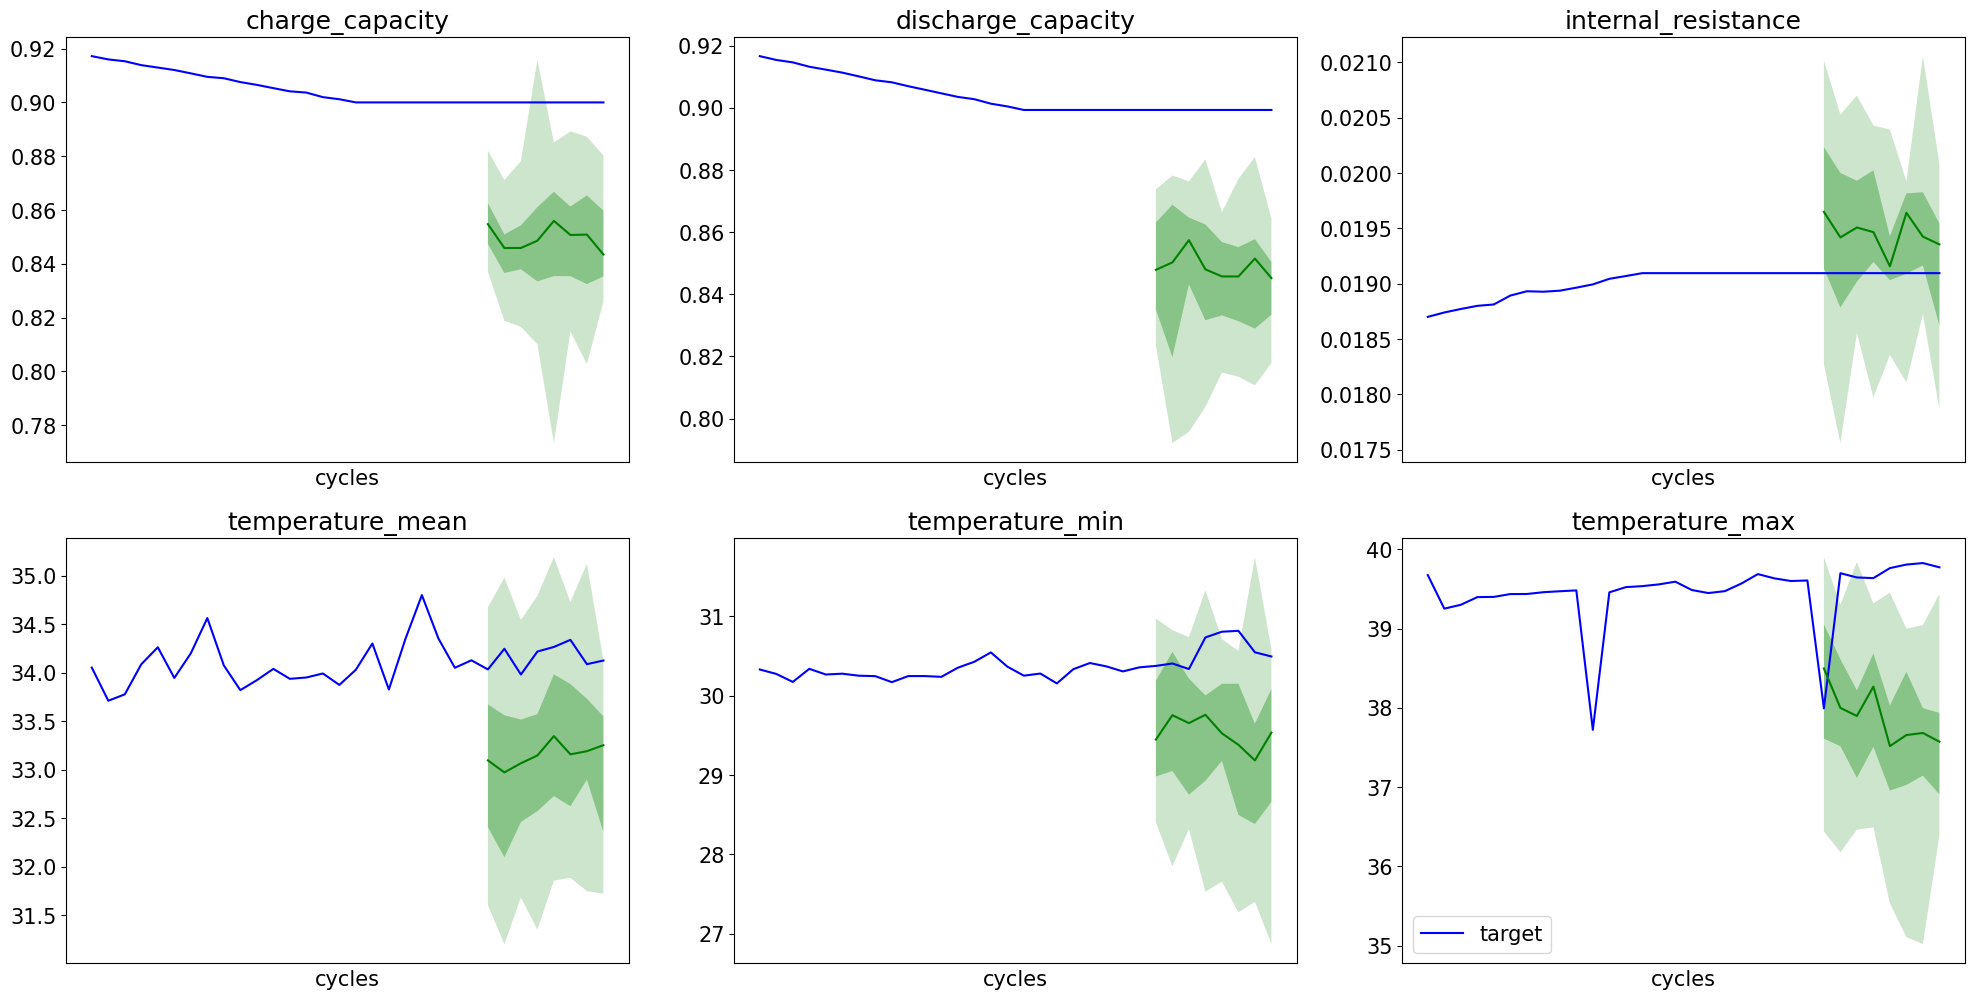

In [102]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%j')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", color='b' )
    forecast.plot( color='g')
    ax.set_xticks([])
    ax.set_xlabel("cycles")
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()